In [1]:
import matplotlib.pyplot as plt
import polars as pl
import os

In [2]:
# Get the absolute path of the current working directory
cwd = os.path.abspath(os.getcwd())

# Get the absolute path of the parent directory of the working directory
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))

# Navigate to the target directory (assuming it is two levels above the working directory)
target_dir = os.path.abspath(os.path.join(parent_dir, os.pardir, 'data'))

In [3]:
# read every parquet file in the data directory, load them all, and then concat together except uniswap-v3 mainnet
# concat all of the balancer-v2 parquet files
balancer_df = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'balancer-v2' in f])

curve_df = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'curve-finance' in f])

In [4]:
# concat balancer and curve
swaps_df = pl.concat([balancer_df, curve_df])

In [5]:
master_swaps_col_list = [
'swaps_hash', 
'swaps_from', 
'swaps_blockNumber',  
'swaps_timestamp',
'swaps_tokenIn_id',
'swaps_amountIn',
'swaps_amountInUSD',
'swaps_tokenOut_id',
'swaps_amountOut',
'swaps_amountOutUSD',
'swaps_pool_id',
'endpoint'
]

In [6]:
# truncate swaps_df based on master list
swaps_df = swaps_df[master_swaps_col_list]

The Messari Uniswap v3 subgraph data has different swap schema columns. The polygon swap schema has the same columns as Balancer and Curve. 
However, the ethereum, arbitrum, and optimism swap schemas have different columns. The most glaring difference is that while Balancer and Curve
swap schemas have swaps_to and swaps_from, the non-comforming Uniswap v3 schemas only have swaps_account_id, which is equivalent to the swaps_from column.

In [7]:
# load each parquet file separately for uniswap-v3. 
df1 = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'uniswap-v3-arbitrum' in f])
df2 = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'uniswap-v3-ethereum' in f])
df3 = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'uniswap-v3-polygon' in f])
df4 = pl.concat([pl.read_parquet(f"{target_dir}/{f}") for f in os.listdir(target_dir) if 'uniswap-v3-optimism' in f])

In [8]:
df1 = df1.rename({'swaps_account_id': 'swaps_from'})
df2 = df2.rename({'swaps_account_id': 'swaps_from'})
df4 = df4.rename({'swaps_account_id': 'swaps_from'})

In [9]:
# truncate df1, df2, df3, df4 based on the master list
df1 = df1[master_swaps_col_list]
df2 = df2[master_swaps_col_list]
df3 = df3[master_swaps_col_list]
df4 = df4[master_swaps_col_list]

In [10]:
#concat df1, df2, df3, df4
uniswap_df = pl.concat([df1, df2, df3, df4])

In [11]:
# concat swaps_df and uniswap_df
swaps_df = pl.concat([swaps_df, uniswap_df])

In [12]:
swaps_df = swaps_df.with_columns(
    pl.from_epoch("swaps_timestamp", unit="s")
)

In [13]:
swaps_df.shape

(1958328, 12)

In [14]:
# this is the dataset we will work with for analysis
swaps_df.head(5)

swaps_hash,swaps_from,swaps_blockNumber,swaps_timestamp,swaps_tokenIn_id,swaps_amountIn,swaps_amountInUSD,swaps_tokenOut_id,swaps_amountOut,swaps_amountOutUSD,swaps_pool_id,endpoint
str,str,i64,datetime[μs],str,f64,f64,str,f64,f64,str,str
"""0xa60f173d822a...","""0xf7995b6b0511...",16816549,2023-03-13 03:59:59,"""0x6b175474e890...",2.9991e22,28643.363471,"""0xae37d54ae477...",2.9918e22,0.0,"""0xae37d54ae477...","""balancer-v2-et..."
"""0x59d3ff71f65a...","""0xf7995b6b0511...",16816533,2023-03-13 03:56:47,"""0xa0b86991c621...",1.9994e10,19947.7118,"""0x82698aecc9e2...",1.9934e22,0.0,"""0x82698aecc9e2...","""balancer-v2-et..."
"""0x06cff3367d7c...","""0x1b84c738c33c...",16816532,2023-03-13 03:56:35,"""0xc02aaa39b223...",1.7152e20,253851.18999,"""0x7f39c581f595...",1.5420e20,276727.804267,"""0x32296969ef14...","""balancer-v2-et..."
"""0x09eff2771522...","""0x1b84c738c33c...",16816531,2023-03-13 03:56:23,"""0xba100000625a...",4.8415e19,312.568058,"""0xc02aaa39b223...",1.9273e17,285.239959,"""0x3ebf48cd7586...","""balancer-v2-et..."
"""0x59aee0705b39...","""0x9b88a69886d0...",16816525,2023-03-13 03:55:11,"""0xdac17f958d2e...",7.5000e10,78013.8,"""0x2f4eb100552e...",7.4360e22,0.0,"""0x2f4eb100552e...","""balancer-v2-et..."


Since we only have the swaps_from values, we will just focus on amountInUSD column for analysis. Here we will just drop all of the nonzero amountInUSD values for simplicity. It looks like it's about 11.27% of total datapoints

In [15]:
amountInZeroCount = swaps_df.filter(pl.col('swaps_amountInUSD') == 0).shape[0]
amountOutZeroCount = swaps_df.filter(pl.col('swaps_amountOutUSD') == 0).shape[0]
swaps_df_size = swaps_df.shape[0]

print(f'amountInZeroCount: {amountInZeroCount}')
print(f'amountOutZeroCount: {amountOutZeroCount}')
print(f'swaps_df size: {swaps_df_size}')

amountInZeroCount: 220858
amountOutZeroCount: 250749
swaps_df size: 1958328


In [16]:
# how many swaps_amountInUSD values are 0?
amountInUSDPercent = swaps_df.filter(pl.col('swaps_amountInUSD') == 0).shape[0] / swaps_df.shape[0]
print(f'The percent of swaps_amountInUSD values that are 0 is {amountInUSDPercent}')

The percent of swaps_amountInUSD values that are 0 is 0.1127788603339175


In [17]:
# swaps_df = swaps_df.filter(pl.col('swaps_amountInUSD') != 0)

### Basic Analysis

In [18]:
# hard coded list of USDC addresses taken from the various _scan.com websites
usdc_list = [
    '0x2791Bca1f2de4661ED88A30C99A7a9449Aa84174', # polygon
    '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', # ethereum
    '0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8', # arbitrum
    '0x7F5c764cBc14f9669B88837ca1490cCa17c31607', # optimism
]

In [19]:
# for every element in usdc_list, convert all uppercase to lowercase
usdc_list = [address.lower() for address in usdc_list]

In [20]:
# filter swaps_df for values in usdc_list
usdc_inflow = swaps_df.filter(pl.col('swaps_tokenIn_id').is_in(usdc_list))
usdc_outflow = swaps_df.filter(pl.col('swaps_tokenOut_id').is_in(usdc_list))

In [23]:
print(f'usdc_inflow size: {usdc_inflow.shape[0]}')
print(f'usdc_outflow size: {usdc_outflow.shape[0]}')

usdc_inflow size: 495582
usdc_outflow size: 453045


In [49]:
# decimal conversion logic
usdc_inflow = usdc_inflow.with_columns([
    (pl.col("swaps_amountIn") / 10**6).alias('swaps_amountIn')
])

usdc_outflow = usdc_outflow.with_columns([
    (pl.col("swaps_amountOut") / 10**6).alias('swaps_amountOut')
])

In [50]:
# group usd_inflow amountInUSD by endpoint
usdc_inflow_grouped = usdc_inflow.groupby('endpoint').agg([pl.sum('swaps_amountIn')]).sort('swaps_amountIn', descending=True)
usdc_outflow_grouped = usdc_outflow.groupby('endpoint').agg([pl.sum('swaps_amountOut')]).sort('swaps_amountOut', descending=True)

In [51]:
# join usdc_inflow_grouped and usdc_outflow_grouped
usdc_inflow_outflow = usdc_inflow_grouped.join(usdc_outflow_grouped, on='endpoint', how='inner')

In [53]:
#first swaps_timestamp date
first_date = swaps_df['swaps_timestamp'].min().strftime('%Y-%m-%d')
#last swaps_timestamp date
last_date = swaps_df['swaps_timestamp'].max().strftime('%Y-%m-%d')

In [62]:
# print the sum of the swaps_amountInUSD and swaps_amountOutUSD
print(f'The total surplus of USDC going into liquidity pools was ${usdc_inflow_outflow["swaps_amountIn"].sum() - usdc_inflow_outflow["swaps_amountOut"].sum():,.2f} from {first_date} to {last_date}.')
print(f'The sum of the swaps_amountIn is ${usdc_inflow_outflow["swaps_amountIn"].sum():,.2f}')
print(f'The sum of the swaps_amountOut is ${usdc_inflow_outflow["swaps_amountOut"].sum():,.2f}')


The total surplus of USDC going into liquidity pools was $668,822,051.10 from 2023-03-09 to 2023-03-13.
The sum of the swaps_amountIn is $12,722,280,129.27
The sum of the swaps_amountOut is $12,053,458,078.16


In [67]:
# for the first 5 rows, print the swaps_amountInUSD and swaps_amountOutUSD
for i in range(0,10):
    print(f'The total surplus of USDC supply going into {usdc_inflow_outflow["endpoint"][i]} LPs was ${usdc_inflow_outflow["swaps_amountIn"][i] - usdc_inflow_outflow["swaps_amountOut"][i]:,.2f}')


The total surplus of USDC supply going into uniswap-v3-ethereum LPs was $205,732,606.41
The total surplus of USDC supply going into curve-finance-ethereum LPs was $365,072,871.63
The total surplus of USDC supply going into uniswap-v3-arbitrum LPs was $6,627,529.05
The total surplus of USDC supply going into uniswap-v3-polygon LPs was $7,093,276.86
The total surplus of USDC supply going into uniswap-v3-optimism LPs was $93,512.27
The total surplus of USDC supply going into curve-finance-arbitrum LPs was $444,585.70
The total surplus of USDC supply going into curve-finance-optimism LPs was $-8,135,060.56
The total surplus of USDC supply going into balancer-v2-ethereum LPs was $95,130,016.70
The total surplus of USDC supply going into balancer-v2-polygon LPs was $1,361,210.85
The total surplus of USDC supply going into curve-finance-polygon LPs was $-7,777,846.31


/tmp/ipykernel_395280/3680472829.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)


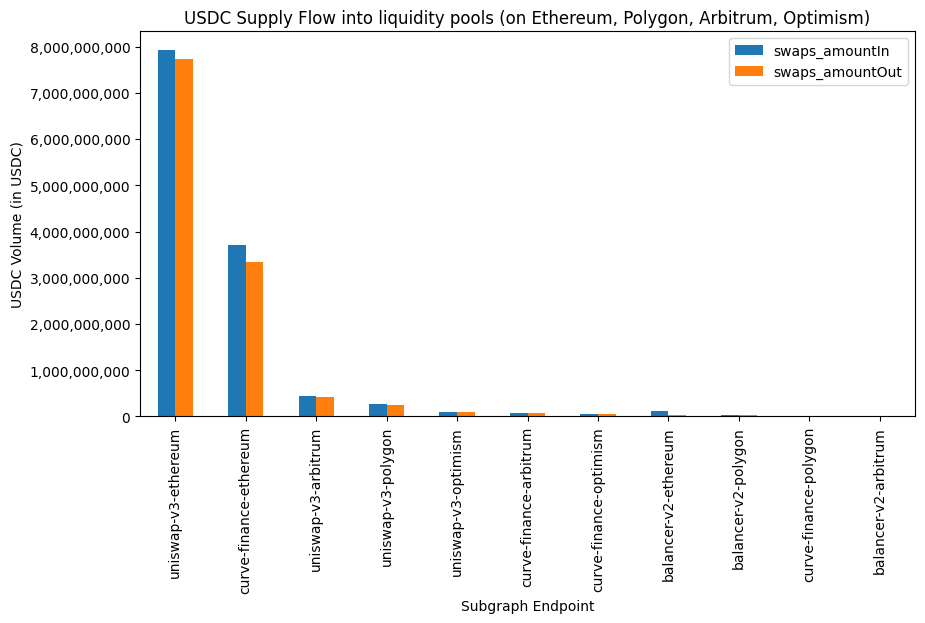

In [63]:
# This chart shows how much dollar volume value is attributed to each protocol on each chain. Top chains in order are Ethereum, Polygon, then Arbitrum
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

# convert to pandas and plot histograms. Label the x-axis and y-axis
usdc_inflow_outflow.to_pandas().plot(kind='bar', x='endpoint', figsize=(10, 5), ax=ax, title='USDC Supply Flow into LPs (on Ethereum, Polygon, Arbitrum, Optimism)')
plt.ylabel('USDC Supply into LPs')
plt.xlabel('Subgraph Endpoint')

# getting the array of values of y-axis
ticks = ax.get_yticks()
# formatted the values into strings beginning with dollar sign
new_labels = [f'{amt:,.0f}' for amt in ticks]
# Set the new labels
ax.set_yticklabels(new_labels)
plt.show();